In [1]:
import sisl
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch


- band
  - Use dptb command with `./band.json` we would see the band structure of hBN in unit cell.
  - `dptb run -sk band.json -i data/model/latest_nnsk_b3.600_c3.600_w0.300.pth -o ./data/band`
  - The results show fermi level is -19.25515365600586

- Transmission
  - It's easy to find that the band gap corresponds to the gap in transmission, showing that transmission $T(E)$ is qualitativly proportional to the Density of States DOS(E).   

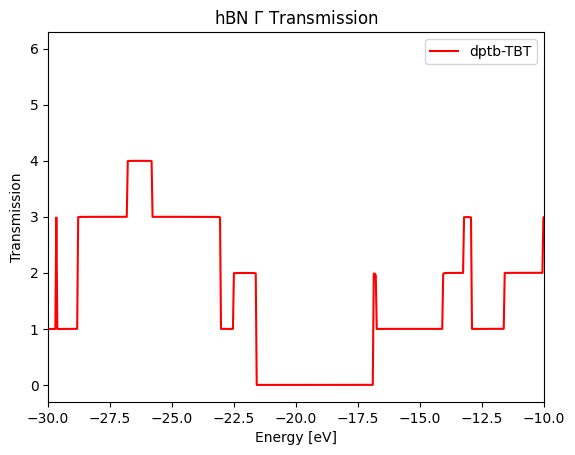

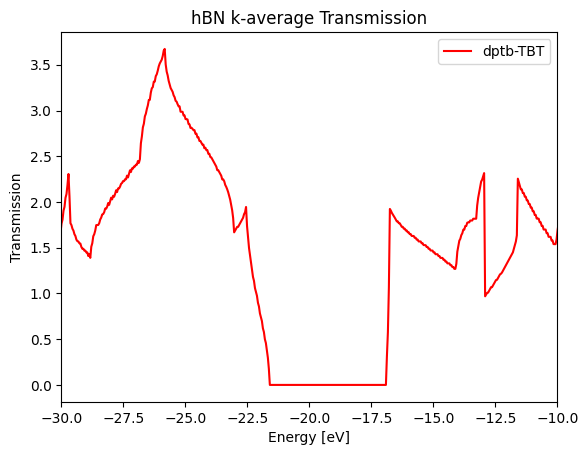

In [2]:
tbt_dptb = sisl.get_sile('./data/dptb_TBT_results/dptb.TBT.nc')


plt.plot(tbt_dptb.E, tbt_dptb.transmission(kavg=tbt_dptb.kindex([0,0,0])),label=r'dptb-TBT',color='r')
plt.title(r'hBN $\Gamma$ Transmission')
plt.ylabel('Transmission'); plt.xlabel('Energy [eV]')
plt.legend()
plt.xlim(-30,-10)
plt.show()

plt.plot(tbt_dptb.E, tbt_dptb.transmission(),label=r'dptb-TBT',color='r')
plt.title(r'hBN k-average Transmission')
plt.ylabel('Transmission'); plt.xlabel('Energy [eV]')
plt.legend()
plt.xlim(-30,-10)
plt.show()

- non-self-consistent current
  - The so called "non-self-consistent current" refers to calculating Current $I$ with zero-bias Transmission $T_0(E)$
  - After applying voltage $V_L$ and $V_R$ in the left and right electrode, $\tilde{\mu}_L = \mu_L - eV_L$,$\tilde{\mu}_R = \mu_R - eV_R$ and the electrochemical potential for the device region is $\tilde{\mu}_d = \mu_d - (eV_L+eV_R)/2$
    -  In function `_cal_current_nscf_`, we set the Fermi level of hBN to 0,thus $\mu_L = \mu_R = \mu_d = 0$
  -  $I = \frac{2e}{h} \int_{-\infty}^{\infty} T_0(E)[f_L(E)-f_R(E)] dE = \frac{2e}{h} \int_{-\infty}^{\infty} T_0(E)[f(E-\mu_L)-f(E-\mu_R)] dE $
  -  Please note that non-self-consistent current is only valid for low-bias transport
  

Text(0.5, 1.0, 'hBN non-SCF I-V')

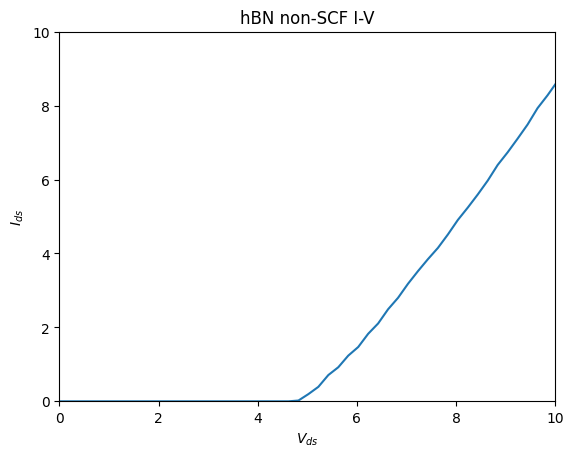

In [21]:
from dptb.utils.constants import Boltzmann, eV2J
from scipy.integrate import simpson
def _cal_current_nscf_(energy_grid, tc):
    '''calculates the non self consistent field (nscf) current.

    Parameters
    ----------
    ee
        unit energy grid points in NEGF calculation
    tc
        Transmission calculated at zero bias voltage
    Returns
    -------
    vv
        voltage range
    cc
        calculated current
    '''
    e_T = 10
    kBT = Boltzmann * e_T / eV2J

    
    f = lambda x,mu: 1 / (1 + torch.exp((x - mu) / kBT))

    emin = energy_grid.min()
    emax = energy_grid.max()
    vmin = emin + 4*kBT
    vmax = emax - 4*kBT
    vm = 0.5 * (vmin+vmax)
    vmid = vm - vmin

    lead_L_efermi = 0; lead_R_efermi = 0;efermi_device = 0 # set the material Fermi level to zero
    mu = efermi_device - vm # electrochemical potential
    vv = torch.linspace(start=0., end=vmid, steps=int(vmid / 0.1)+1) * 2
    cc = []

    for dv in vv * 0.5:
        I = simpson((f(energy_grid+mu, lead_L_efermi-vm+dv) - f(energy_grid+mu, lead_R_efermi-vm-dv)) * tc, energy_grid)
        cc.append(I)

    return vv, cc



efermi_dptb = -19.25515365600586
delta_E = 0.0
Erange = torch.from_numpy(tbt_dptb.E - efermi_dptb + delta_E) # set the Fermi level to zero
trans = torch.from_numpy(tbt_dptb.transmission())
voltage, current = _cal_current_nscf_(Erange, trans)


plt.plot(voltage,current)
plt.xlabel(r'$V_{ds}$')
plt.ylabel(r'$I_{ds}$')
plt.xlim(0,10)
plt.ylim(0,10)
plt.title('hBN non-SCF I-V')

In [26]:
tbt_dptb.E.min()

-39.229649911295866

In [25]:
tbt_dptb.E.max()

-4.26996189449996